# Preamble

In [1]:
import numpy as np
import spinmob as s

In [80]:
from sympy import sympify
from scipy.optimize import minimize

Load in data (1=rigel, 2=joseph, 3=miles) and convert inches to cm:

In [59]:
datafilenames = ["calibration_data"+str(i)+".csv" for i in range(1, 4)]
calibration_datas = [s.data.load(datafilename) for datafilename in datafilenames]
#added_voltage_error = 0.05
inch_to_cm = 2.54
for calibration_data in calibration_datas:
    calibration_data[0] *= inch_to_cm
    calibration_data[2] *= inch_to_cm
    calibration_data[3] += added_voltage_error

Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: measurements?)
Extra ckey: bad
Extra ckey: to
Extra ckey: due
Extra ckey: 0.003
Extra ckey: to
Extra ckey: up
Extra ckey: take
Extra ckey: (maybe
Extra ckey: errors
Extra ckey: Height


Convert to relative heights:

In [60]:
for calibration_data in calibration_datas:
    calibration_data[0] -= np.max(calibration_data[0])
    calibration_data[0] *= -1
    calibration_data[2] *= 2

Chop data so they have some all overlapping:

In [61]:
for calibration_data in calibration_datas:
    max_range = np.argmin(np.abs(calibration_data[0] - 0.45))+1
    for i in range(4):
        calibration_data[i] = calibration_data[i][:max_range]

for calibration_data in calibration_datas:
    min_range = np.argmin(np.abs(calibration_data[0] - 0.15))
    for i in range(4):
        calibration_data[i] = calibration_data[i][min_range:]

Generate plots for each:

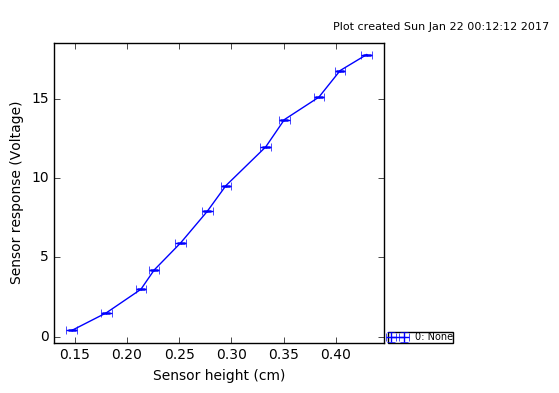

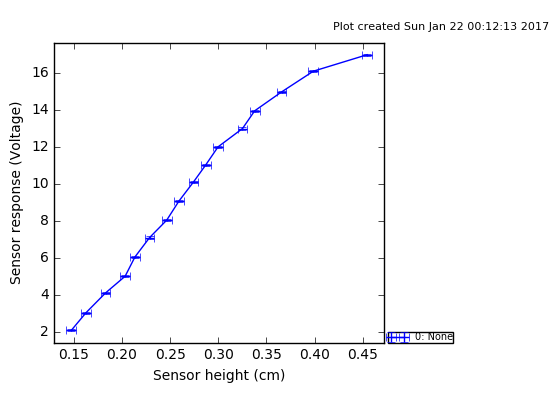

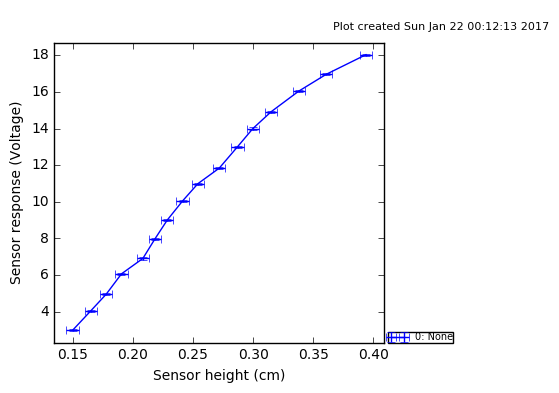

In [62]:
for i, calibration_data in enumerate(calibration_datas):
    fig = s.pylab.figure()
    ax = fig.add_axes([0,0,1,1])
    s.plot.xy.data(
        xdata=calibration_data[0], ydata=calibration_data[1],
        exdata=calibration_data[2], eydata=calibration_data[3],
        xlabel="Sensor height (cm)", ylabel="Sensor response (Voltage)")
    #s.pylab.savefig("calibration_curve"+str(i+1)+".pdf", bbox_inches='tight')

Try to overlap using polynomials:

Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).



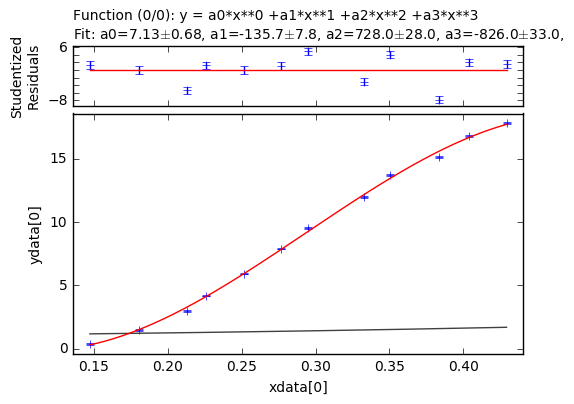

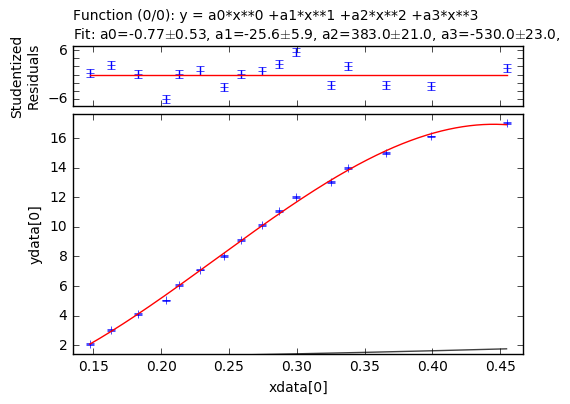

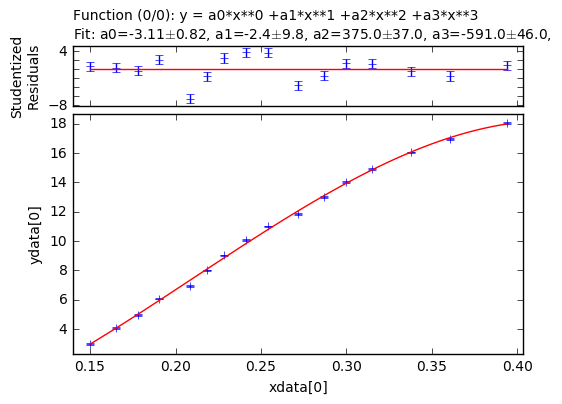

In [63]:
#nth order fitter:
n=4
all_fit_params = []
for calibration_data in calibration_datas:
    my_fitter = s.data.fitter(
        f=''.join(['a'+str(i)+'*x**'+str(i)+' +' for i in range(n)])[:-1], 
        p=''.join(['a'+str(i)+', ' for i in range(n)])[:-2])
    
    #Turns off autoplot
    my_fitter._settings['autoplot'] = False
    my_fitter.set_data(
        xdata=calibration_data[0], ydata=calibration_data[1],
        exdata=calibration_data[2], eydata=calibration_data[3])
    my_fitter.fit()
    my_fitter.plot()
    all_fit_params.append(my_fitter.results[0])

Load all the fit functions:

In [72]:
all_fit_functions = []
for calibration_number in range(3):
    function =''.join([str(all_fit_params[calibration_number][i])+'*x**'+str(i)+' +' for i in range(n)])[:-1]
    all_fit_functions.append(sympify(function))

Try to get the region of maximal overlap between polynomials:

In [101]:
def point_error(function_num, x, offset): 
    error = all_fit_functions[0].subs("x", x) - \
        all_fit_functions[function_num].subs("x", x+offset)
    return error

def full_squared_error(function_num, offset):
    domain = np.linspace(0.2, 0.375, 10)
    accumulated_error = 0
    for x in domain:
        accumulated_error += np.square(point_error(function_num, x, offset))
    return accumulated_error

def total_error_func1(offset):
    return full_squared_error(1, offset)

def total_error_func2(offset):
    return full_squared_error(2, offset)

In [111]:
best = -0.0333331111111
radius_of_test = 0.005
for x in np.linspace(best-radius_of_test, best+radius_of_test, 10):
    print(total_error_func1(x), x)

4.46972867712586 -0.0383331111111
4.06774869782766 -0.037222
3.76214922856611 -0.0361108888889
3.55281475362572 -0.0349997777778
3.43960893855761 -0.0338886666667
3.42237466884835 -0.0327775555555
3.50093409239827 -0.0316664444444
3.67508866580902 -0.0305553333333
3.94461920448058 -0.0294442222222
4.30928593651744 -0.0283331111111


This says that the best offset value for the second data set in comparison with the first is -0.0327775555555 cm off. 

Let's try it with the next data set:

In [116]:
best = -0.0594444444445
radius_of_test = 0.005/2
for x in np.linspace(best-radius_of_test, best+radius_of_test, 10):
    print(total_error_func2(x), x)

0.425445559188395 -0.0619444444445
0.313784741424778 -0.0613888888889
0.233450537897369 -0.0608333333334
0.184411679883140 -0.0602777777778
0.166635223334167 -0.0597222222223
0.180086550939253 -0.0591666666667
0.224729374259649 -0.0586111111112
0.300525735938575 -0.0580555555556
0.407436011984760 -0.0575000000001
0.545418914129904 -0.0569444444445


So this tells us that the third data set in comparison with the first is -0.0594444444445 cm off. 

Try to produce some linear fits:

In [ ]:
np.load('results_of_linear_fits.npy')

In [ ]:
def obtain_fit_results(calibration_data):
    fit_results = []
    for start in range(0, 8):
        for length in range(3, 7):
            my_fitter = s.data.fitter(f='a*x + b', p='a, b')
            length_of_regression = length
            start_of_regression = start
            end_of_regression = start_of_regression + length_of_regression
            my_fitter.set_data(
                xdata=calibration_data[0][start_of_regression:end_of_regression],
                ydata=calibration_data[1][start_of_regression:end_of_regression],
                exdata=calibration_data[2][start_of_regression:end_of_regression],
                eydata=calibration_data[3][start_of_regression:end_of_regression])
            my_fitter.fit()
            chi_squared = my_fitter.reduced_chi_squareds()[0]
            fit_results.append([start, length, chi_squared])
    return fit_results

In [ ]:
fit_results = np.array(fit_results)
smallest_chi_square = np.argmin(fit_results[:, 2])
print("The best chi-squared is", 
      fit_results[smallest_chi_square, 2],
      "for position", fit_results[smallest_chi_square, :2])
start_position = fit_results[smallest_chi_square, 0]
length = fit_results[smallest_chi_square, 1]
print("This voltage is",
      calibration_data[1][start_position],
      "to",
      calibration_data[1][start_position+length])

In [ ]:
my_fitter = s.data.fitter(f='a*x + b', p='a, b')
length_of_regression = length
start_of_regression = start_position
end_of_regression = start_of_regression + length_of_regression
my_fitter.set_data(
    xdata=calibration_data[0][start_of_regression:end_of_regression],
    ydata=calibration_data[1][start_of_regression:end_of_regression],
    exdata=calibration_data[2][start_of_regression:end_of_regression],
    eydata=calibration_data[3][start_of_regression:end_of_regression])
my_fitter.fit()